[Section 1](#section_1)

## Imports

In [5]:
import pandas as pd
import os
import numpy as np
from neo4j import GraphDatabase
import re
from functools import reduce
import matplotlib as plt

## Functions 

### Using Naming Conventions

In [5]:
def convert_using_naming():
    nodesNames = ('supplier', 'customer',  'retailer','service providers', 'distributors', 'sales channels', 'consumers', 'producers', 'vendors', 'transportation', 'wholesaler', 'distribution center', 'warehouses')

    for name in list(All_dfs.keys()):
        lowerCasedName = name.lower()
        if(lowerCasedName in nodesNames):
            nodes.add(lowerCasedName)

### Find Each Table's primary key

In [6]:
def pk_finder(name, df):
    for i in range(len(df.columns)):
        col = df.iloc[:,i]
        #if(col.size == col.drop_duplicates().size):
        if(col.nunique() == col.size):
            pk[name] = df.columns[i] 
            break
        

### Find Each Table's foreign key


In [7]:
def fk_finder(name, df):
    for i in range(len(df.columns)):
        col_name = df.columns[i]
        col = df[col_name]
        for j in pk: #loops on the key j = table names
            if j != name:
                primary_key_column = All_dfs[j][(pk[j])]
                
                if primary_key_column.dtype == col.dtype:
                    status = col.isin(primary_key_column)
                    if status[status== False].size == 0:
                        fk[name][col_name] = j 
                        ref_in[j].add(name)
                        break

                elif (isinstance(col[0],list) and len(df[col.isin([[]])])==0 and type(primary_key_column[0]) == type(col[0][0])):
                    status = col.explode().reset_index(drop=True).isin(primary_key_column)
                    if status[status== False].size == 0:
                        fk[name][col_name] = j 
                        ref_in[j].add(name)
                        break

In [8]:
# type(All_dfs["warehouses"].warehouse_id[0])

### Assign Tables to nodes or edges

In [9]:
def nodes_edges(fk):
    for f in fk:
        if(f not in ['ssintorders','manufacturing']):
            if len(fk[f]) == 2:
                inner_dict = list(fk[f])
                edges.add(f)
            elif len(fk[f]) == 1:
                properties.add(f)
            # elif len(fk[f]) == 0:
            #     nodes.add(f)


### Create Nodes Table

In [10]:
def add_nodes(nodes, nodesTable):
    for node in nodes:
#     for n in range(len(nodes)):
        column_names = list(All_dfs[node].columns) #get column names
        for index,row in All_dfs[node].iterrows():
#         for index, row in nodes[list(nodes.keys())[n]].iterrows():
            
            att = {}
            for i in range(1, len(column_names)):
                att[column_names[i]] = All_dfs[node].iloc[index, i]
#                 att[column_names[i]] = nodes[list(nodes.keys())[n]].iloc[index, i]
                
            newRow = [{'Label': node , 'ID': All_dfs[node].iloc[index,0] , 'Attributes': att}]
            tmp = pd.DataFrame(newRow)
            nodesTable = pd.concat([nodesTable, tmp], ignore_index=True)
    return nodesTable

def add_nodesV2(nodeNames, nodesTB):
    for node in nodeNames:
        print(node)
        dfNumpy =  All_dfs[node].to_numpy()
        # All_dfs.pop(node)
        allDfsKeys.remove(node)
        for row in dfNumpy:
            newRow = [{'Label': node, 'ID': row[0] , 'Attributes': row[1:]}]
            tmp = pd.DataFrame(newRow)
            nodesTB = pd.concat([nodesTB, tmp], ignore_index=True)
    return nodesTB


### Create Edges Table

In [11]:
def add_edges(edges,edgesTable,pk,fk,ref_in):
    
    for e in edges:
        df = All_dfs[e] #df of the cur edge
        for r in range(len(df)):
            label = list(fk[e].keys())
            from_id = nodesTable[(nodesTable["Label"] == fk[e][label[0]]) & (df.loc[r,label[0]] == nodesTable["ID"])]
            from_id = from_id.index[0]
            to_id = nodesTable[(nodesTable["Label"] == fk[e][label[1]]) & (df.loc[r,label[1]] == nodesTable["ID"])]
            to_id = to_id.index[0]
            pk_col = pk[e]
#             primary_key = df[pk_col].iloc[r]
            primary_key = df.loc[r,pk_col]
            att = convert_prop(ref_in,e,primary_key,fk)
            newRow = [{'From_Node_ID': from_id, 'To_Node_ID': to_id, 'order/service' : att}]
            tmp = pd.DataFrame(newRow)
            edgesTable = pd.concat([edgesTable, tmp], ignore_index=True)
    return edgesTable

def add_edgesV2(edges,edgesTable,pk,fk,ref_in):
    for e in edges:
        df = All_dfs[e] #df of the cur edge
        dfNumpy =  df.to_numpy()
        for row in dfNumpy:
            label = list(edges[e].keys())
            indexOfFromColumn =  list(df.columns).index(label[0])
            from_id = nodesTableV1[(nodesTableV1["Label"] == edges[e][label[0]]) & (row[indexOfFromColumn] == nodesTableV1["ID"])]
            from_id = from_id.index[0]
            indexToFromColumn =  list(df.columns).index(label[1])
            to_id = nodesTableV1[(nodesTableV1["Label"] == edges[e][label[1]]) & (row[indexToFromColumn] == nodesTableV1["ID"])]
            to_id = to_id.index[0]
            pk_col = pk[e]
            primary_key = row[list(df.columns).index(pk_col)]
            att = convert_prop(ref_in,e,primary_key,fk)
            newRow = [{'From_Node_ID': from_id, 'To_Node_ID': to_id, 'order/service' : att}]
            tmp = pd.DataFrame(newRow)
            edgesTableV1 = pd.concat([edgesTableV1, tmp], ignore_index=True)
    return edgesTable

### Properties of the Edge

In [12]:
def convert_prop(ref_in,edge_key, pk_value,fk):
    for referenced_table_name in ref_in[edge_key]:
        referenced_table = All_dfs[referenced_table_name]
        fk_of_ref_table = fk[referenced_table_name]
        for foreign_key in fk_of_ref_table:
            if fk_of_ref_table[foreign_key] == edge_key:
#                 referenced_table[referenced_table[foreign_key]== id]
                all_occurances_df = referenced_table[referenced_table[foreign_key]== pk_value].drop([foreign_key],axis=1)
                return all_occurances_df.to_dict('records')
                

### generate list of n colors

In [13]:
import random
get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
# get_colors(5) # sample return:  ['#8af5da', '#fbc08c', '#b741d0', '#e599f1', '#bbcb59', '#a2a6c0']

### Draw Pyvis graph

In [14]:
def draw_graph_pyvis(nodes_table,edges_table):

    nodes_name = [(x[1]+'_'+str(x[0])).capitalize() for x in zip(nodes_table.ID,nodes_table.Label)]
    indices = list(map(lambda x: int(x),list(nodes_table.index)))
    nodes_attributes = list(map(lambda x: str(x).replace(',',"\n"),list(nodes_table.Attributes)))
    nodes_tables = list(nodes_df.Label.unique())
    colors = get_colors(len(nodes_name))
    nodes_color = list(map(lambda x: colors[nodes_tables.index(x)],list(nodes_table.Label)))
    
    g = Network(width='100%')
#     g.barnes_hut()
    g.add_nodes(indices,
                title= nodes_attributes,
                label=nodes_name,
                color=nodes_color,
                )
    for e in range(len(edges_table)):
        src = int(edges_table.iloc[e]["From"])
        dst = int(edges_table.iloc[e]["To"])
        g.add_edge(src,dst,weight=5)

    print("Number of Nodes: ",len(g.get_nodes()))
    print("Number of Edges: ",len(g.get_edges()))
    

    g.show('test.html')




### Draw Graph Neo4j

<a id='Neo4jFunction'></a>

[Noe4jCallFunction](#Neo4jCall)

#### prepare satements

In [15]:
def draw_graph_Neo4j(nodes_table,edges_table):

    transaction_execution_commands = []
    transaction_execution_commands.append("match (n) detach delete n")
    # creating a statement for each node (row in node_table)
    for i, node in nodes_table.iterrows():
        label = node["Label"].capitalize()
        index = i
        IDs = node["ID"]
        attributes = node["Attributes"]
        neo4j_create_statement = Create_Statement(label,i,IDs,attributes)
        transaction_execution_commands.append(neo4j_create_statement)

    for i, edge in edges_table.iterrows():

        neo4j_create_statement = create_relation_statement(edge)
        transaction_execution_commands.append(neo4j_create_statement)

     
    execute_transactions(transaction_execution_commands)
 

#### Connect and execute statements

In [16]:
def execute_transactions(transaction_execution_commands):
    data_base_connection = GraphDatabase.driver(uri = "bolt://localhost:7687", auth=("neo4j", "password"))
#     session = data_base_connection.session()    
    with data_base_connection.session() as session:
        for i in transaction_execution_commands:
            session.execute_write(lambda tx,i: tx.run(i),i)
            #execute_read

 

#### Create a "Create statement for nodes"

In [17]:
def Create_Statement(label,index,IDs,attributes):
#     att = destructure_dict(attributes)
#     return f"CREATE (x:{label} {'{'}name: {get_name(label,IDs)},index:{index},ID:{IDs} ,{destructure_dict(attributes)} {'}'})"
    att = (", " + destructure_dict(attributes)) if len(attributes) > 0 else ""
    return f"CREATE (x:{label} {'{'}name: {get_name(label,IDs)},index:{index},ID:{IDs} {att} {'}'})"


In [18]:
def get_name(label,ID):
    return '\"' + label.capitalize()+' '+str(ID)+'\"'

#### prepare attributes for create statement

In [19]:
def destructure_dict(dic):
    s = ""
    for key in dic:
        value = dic[key]
        if isinstance (value,str):
            value = "\"" + value +"\""
        s=s + re.sub("[^\w_]", '',str(key).replace(" ","_")) + ":" + str(value)+","
    return s[:-1]

In [20]:
def create_relation_statement(edge):
        from_id = edge['From']
        to_id = edge['To']
        from_name = edge['From_Table']
        to_name = edge['To_Table']
        rel_name = edge['Edge_Name']
        w = edge['Weight']
        return f"Match (a:{from_name}),(b:{to_name}) WHERE a.index ={from_id} AND b.index = {to_id} CREATE (a) - [r:{rel_name} {'{ weight: '+ str(w) +' }'}]->(b)"


In [21]:
def and_agg(series):
       return reduce(lambda x, y: x and y, series)

## Global Variables

In [22]:
# {Table name: df}
All_dfs = {}
# {Table name: Table's Primary key}
pk = {}
# {Table name: {Column Name: Referenced Table}}
fk = {}
# {Table name: set(Tables that references the table)}
ref_in = {}
# {Table name: df}
nodes = set()
# {Table name: {Column Name: Referenced Table}}
edges = set()
# _
properties = set()
# Nodes_df
nodesTable = pd.DataFrame(columns=['Label', 'ID', 'Attributes'])
# Edges_df
edgesTable = pd.DataFrame(columns = ['From_Node_ID', 'To_Node_ID', 'order/service'])
# Properties_df
propertiesTable = pd.DataFrame(columns = [['index','From', 'Label', 'Attributes']])
#Label = ['facilities'/ 'order' / 'service']


# Nodes
# Edges ['From_Node_ID', 'To_Node_ID']
# Properties ['Label', 'ID', 'Attributes']
# (^Nodes in graph)
# Relationship ["Relation_name","from","to"]


nodes_df = pd.DataFrame(columns=['Label', 'ID', 'Attributes'])
edges_df = pd.DataFrame(columns=['From','To','From_Table','To_Table','Weight','Edge_Name'])


<a id='section_1'></a>
## Reading Data Set


 creating a dictionary where
 key: first word of the table name 
 value: df 

In [33]:
import os
path_of_the_directory = './DataSet/'
ext = ('.csv')
for file in os.listdir(path_of_the_directory):
    if file.endswith(ext):
        print(file) 
        temp = (file.replace("_"," ").replace("."," ").split(" ")[0].lower())
        All_dfs[temp] = pd.read_csv(path_of_the_directory+file)
    else:
        continue

for table_nm in All_dfs:
    table = All_dfs[table_nm]
    for column_name in table.columns:
        column =  table[column_name]
        if column.dtype=='O' and isinstance(column[0],str):
            if  (isinstance(column[0],str) and column.apply(lambda x: (str(x).startswith('[') and str(x).endswith(']'))
                         or 
                         (str(x).startswith('(') and str(x).endswith(')'))).agg(and_agg)):
                print(table_nm,column_name)

                s = column.apply(lambda x: x.strip("[](,)").split(','))
                if (s[0][0].isdigit()):
                    
                    new_s = pd.Series(dtype=object)                
                    for index,item in s.iteritems():
                        new_item = []
                        for element in item:
                            new_item.append(np.int64(element))
                        new_s.at[index] = new_item
                    s=new_s

                else:
                    new_s = pd.Series(dtype=object)                
                    for index,item in s.iteritems():
                        new_item = []
                        for element in item:
                            new_item.append(element.strip().strip('"').strip("'").strip())
                        new_s.at[index] = new_item
                    s=new_s

                All_dfs[table_nm][column_name] = s
                


customer_data.csv
ExternalOrders_data.csv
ExternalServices_data.csv
ExternalShipments_data.csv
ExternalTransactions.csv
facilities_data.csv
InternalOrders_data.csv
InternalServices_data.csv
InternalShipments_data.csv
InternalTransactions.csv
Manufacturing_data.csv
Products_data.csv
Retailer_data.csv
Supplier_data.csv
warehouses_data.csv
manufacturing Different_suppliers
products warehouses
warehouses product_types
B


In [34]:
type([])

list

In [35]:
print(type(np.int64("2")))

<class 'numpy.int64'>


In [36]:
All_dfs['manufacturing']['Different_suppliers'].dtype

dtype('O')

In [37]:
All_dfs["products"].warehouses.explode().isin(All_dfs["warehouses"].warehouse_id ).agg(and_agg)

True

In [38]:
# ware_house_id = All_dfs["warehouses"].warehouse_id 

# warehouse_product_isin_warehouse = All_dfs["products"].warehouses.explode().isin(ware_house_id)
# warehouse_product_not_in_warehouse_values = list(All_dfs["products"].warehouses.explode()[[not elem for elem in warehouse_product_isin_warehouse]].unique())
# print(len(warehouse_product_not_in_warehouse_values))
# warehouse_isin_warehouse_product =  ware_house_id.isin(All_dfs["products"].warehouses.explode())
# print(len( list(ware_house_id[[not elem for elem in warehouse_isin_warehouse_product]].unique())))
# warehouses_to_be_replaced = list(ware_house_id[[not elem for elem in warehouse_isin_warehouse_product]].unique())[:len(warehouse_product_not_in_warehouse_values)]

# All_dfs["warehouses"].warehouse_id  =  ware_house_id.replace(warehouses_to_be_replaced,warehouse_product_not_in_warehouse_values)

### Adding Missing Edges


In [39]:
initial_internalshipments_df = All_dfs["internalshipments"]
initial_internalshipments_df

,IntShip_id,listSuppIds,factoryIds,from_to_where,TransportationType
0,7281,90942,52160,SS,Land
1,5897,36243,67361,SR,Air
2,3477,87916,30692,SS,Land
3,8796,90236,26533,SS,Sea
4,2360,89467,46954,SR,Air
...,...,...,...,...,...
583,10478,42179,46070,SS,Sea
584,10479,48467,46070,SS,Sea
585,10480,70468,18952,SS,Air
586,10481,48580,18952,SS,Land


In [40]:
c = 9995
from_shipment = All_dfs["internalshipments"].listSuppIds
to_shipment = All_dfs["internalshipments"].factoryIds

for r in range(len(All_dfs["manufacturing"])):
    diff_supp = All_dfs["manufacturing"].loc[r,"Different_suppliers"]
    factory = All_dfs["manufacturing"].loc[r,"Factory_id"]
    for s in range(len(diff_supp)):
        
        supp = diff_supp[s]
        if supp == factory:
            print(factory)
        if len(All_dfs["internalshipments"].query(f"listSuppIds == {supp} and factoryIds == {factory}")) ==0:
            new_row = [{"IntShip_id":c, "listSuppIds":supp, "factoryIds": factory, "from_to_where": "SS"}] 
            df = pd.DataFrame(new_row)
            c = c+1
            All_dfs["internalshipments"] = pd.concat([All_dfs["internalshipments"], df], ignore_index=True)

#         if (supp not in from_shipmentfrom_shipment)  :
#                 if factory in All_dfs["supplier"].supp_id:
#                     i = "SS"

#         new_row = [{"IntShip_id":c, "listSuppIds":diff_supp[s], "factoryIds": factory, "from_to_where": i}] 
#         df = pd.DataFrame(new_row)
#         c = c+1
#         All_dfs["internalshipments"] = pd.concat([All_dfs["internalshipments"], df], ignore_index=True)
      

### Adding Missing Orders


In [41]:
orders_int_ship_id = All_dfs["internalorders"].IntShip_id	
internal_ship_id = All_dfs["internalshipments"].IntShip_id
ship_id_in_orders_ship_id = internal_ship_id.isin(orders_int_ship_id)
ship_id_not_in_orders_ship_id = list(All_dfs["internalshipments"].IntShip_id[[not elem for elem in ship_id_in_orders_ship_id]].unique())
len(ship_id_not_in_orders_ship_id)

522

In [42]:
c = 9931
for id in ship_id_not_in_orders_ship_id:
    new_row = [{"IntOrders_id":c, "IntShip_id":id, "quantity": 766, "placed_when": "1993-05-08",
    "actual_date":"1993-05-30 00:00:00", "expected_date":"1993-06-01", "cost":"38.90", "status":"Closed"}] 
    df = pd.DataFrame(new_row)
    c = c+1
    All_dfs["internalorders"] = pd.concat([All_dfs["internalorders"], df], ignore_index=True)


In [43]:
display(All_dfs["internalshipments"])

IntShip = All_dfs["internalshipments"].shape[0]
#SRIntShip
ExtShip = All_dfs["externalshipments"].shape[0]

types = ['Air', 'Sea', 'Land']

a = np.array([random.choice(types) for x in range(IntShip)])
b = np.array([random.choice(types) for x in range(ExtShip)])
 
serIntShip = pd.Series(a)
serExtShip = pd.Series(b) 

All_dfs["internalshipments"]['TransportationType'] = serIntShip
#SRIntShip
All_dfs["externalshipments"]['TransportationType'] = serExtShip

All_dfs["internalshipments"]

,IntShip_id,listSuppIds,factoryIds,from_to_where,TransportationType
0,7281,90942,52160,SS,Land
1,5897,36243,67361,SR,Air
2,3477,87916,30692,SS,Land
3,8796,90236,26533,SS,Sea
4,2360,89467,46954,SR,Air
...,...,...,...,...,...
583,10478,42179,46070,SS,Sea
584,10479,48467,46070,SS,Sea
585,10480,70468,18952,SS,Air
586,10481,48580,18952,SS,Land


,IntShip_id,listSuppIds,factoryIds,from_to_where,TransportationType
0,7281,90942,52160,SS,Sea
1,5897,36243,67361,SR,Land
2,3477,87916,30692,SS,Land
3,8796,90236,26533,SS,Land
4,2360,89467,46954,SR,Land
...,...,...,...,...,...
583,10478,42179,46070,SS,Sea
584,10479,48467,46070,SS,Air
585,10480,70468,18952,SS,Land
586,10481,48580,18952,SS,Sea


### Splitting Shipments tables

In [44]:
SRIntShip = All_dfs["internalshipments"].query('from_to_where == "SR"')
SRIntShip = SRIntShip.drop(['from_to_where'], axis=1).reset_index(drop = True)
#SRIntShip
RCExtShip = All_dfs["externalshipments"].query('from_to_where == "RC"')
RCExtShip = RCExtShip.drop(['from_to_where'], axis=1).reset_index(drop = True)
#RCExtShip
SSIntShip = All_dfs["internalshipments"].query('from_to_where == "SS"')
SSIntShip = SSIntShip.drop(['from_to_where'], axis=1).reset_index(drop = True)
#SSIntShip
SCExtShip = All_dfs["externalshipments"].query('from_to_where == "SC"')
SCExtShip = SCExtShip.drop(['from_to_where'], axis=1).reset_index(drop = True)
#SCExtShip
All_dfs["RCExtShip".lower()] = RCExtShip
All_dfs["SCExtShip".lower()] = SCExtShip
All_dfs["SRIntShip".lower()] = SRIntShip
All_dfs["SSIntShip".lower()] = SSIntShip

### Splitting Orders Tables

In [45]:
filter_list = All_dfs["rcextship"]["ExtShip_id"]
All_dfs["rcextorders"] = All_dfs["externalorders"][All_dfs["externalorders"].ExtShip_id.isin(filter_list)].reset_index(drop=True)
filter_list = All_dfs["scextship"]["ExtShip_id"]
All_dfs["scextorders"] = All_dfs["externalorders"][All_dfs["externalorders"].ExtShip_id.isin(filter_list)].reset_index(drop=True)
#All_dfs["scextorders"] = All_dfs["externalorders"].query("ExtShip_id.isin(@filter_list)").reset_index(drop=True)
filter_list = All_dfs["srintship"]["IntShip_id"]
All_dfs["srintorders"] = All_dfs["internalorders"][All_dfs["internalorders"].IntShip_id.isin(filter_list)].reset_index(drop=True)
#All_dfs["srintorders"] = All_dfs["internalorders"].query("IntShip_id.isin(@filter_list)").reset_index(drop=True)
filter_list = All_dfs["ssintship"]["IntShip_id"]
All_dfs["ssintorders"] = All_dfs["internalorders"][All_dfs["internalorders"].IntShip_id.isin(filter_list)].reset_index(drop=True)
#All_dfs["ssintorders"] = All_dfs["internalorders"].query("IntShip_id.isin(@filter_list)").reset_index(drop=True)

### Removing Redundant Tables

In [46]:
All_dfs.pop("internalshipments")
All_dfs.pop("externalshipments")
All_dfs.pop("externalorders")
All_dfs.pop("internalorders")
All_dfs.keys()

dict_keys(['customer', 'externalservices', 'externaltransactions', 'facilities', 'internalservices', 'internaltransactions', 'manufacturing', 'products', 'retailer', 'supplier', 'warehouses', 'rcextship', 'scextship', 'srintship', 'ssintship', 'rcextorders', 'scextorders', 'srintorders', 'ssintorders'])

In [47]:
supplier_to_retailer_shipment_df = All_dfs["srintship"]
retailer_df = All_dfs["retailer"]
supplier_df = All_dfs["supplier"]
suppliers_ids_in_shipments = list(supplier_to_retailer_shipment_df.listSuppIds.unique())
suppliers_in_shipments_df = supplier_df[supplier_df["supp_id"].isin(suppliers_ids_in_shipments)]
retailers_types_column = []
for _, retialer_row in retailer_df.iterrows():
        retailer_types = set()
        retailer_id = retialer_row.retailer_id
        shipments_with_retailer_df = supplier_to_retailer_shipment_df[supplier_to_retailer_shipment_df.factoryIds == retailer_id]
        for _,shipment_row in shipments_with_retailer_df.iterrows():
            supplier_id = shipment_row.listSuppIds
#             print(suppliers_in_shipments_df[suppliers_in_shipments_df.supp_id == supplier_id].iloc[0].type)
            supplier_type = suppliers_in_shipments_df[suppliers_in_shipments_df.supp_id == supplier_id].iloc[0].type
            retailer_types.add(supplier_type)
        retailers_types_column.append(list(retailer_types))

retailer_df["RetailerTypes"] = retailers_types_column
All_dfs["retailer"]=retailer_df

In [48]:
retailer_df[retailer_df["RetailerTypes"].isin([[]])]

,retailer_id,country,city_name,type,reviews_number,rating,opening_hours,capacity (units),RetailerTypes
0,91089,Tunisia,Kairouan,distributer,650,5,7,169554,[]
1,95444,Kuwait,Al Farwānīyah,vendor,441,1,8,325442,[]
2,66051,Qatar,Ash Shīḩānīyah,abroad,821,2,9,426160,[]
4,34083,Gambia,Banjul,vendor,815,4,7,1843949,[]
6,12318,Tajikistan,Kŭhistoni Badakhshon,vendor,356,3,8,1133068,[]
...,...,...,...,...,...,...,...,...,...
144,76954,Montenegro,Rožaje,distributer,191,5,3,309798,[]
146,18464,Haiti,Grandans,customer end,295,2,5,1686073,[]
147,57039,Lao People's Democratic Republic,Viangchan,vendor,450,2,7,1019346,[]
148,33250,South Sudan,Lakes,customer end,318,4,6,716050,[]


In [49]:
# for table in All_dfs:
#     print(table)
#     print(All_dfs[table].isna().sum())
#     print("_________________________")

### Removing nan

In [50]:
for table in All_dfs:
    All_dfs[table].fillna('Unknown',inplace = True)


### Execlude Tables

In [51]:
# All_dfs = {key: value for key, value in All_dfs.items() 
#            if key not in ["products","warehouses","manufacturing"]}
# All_dfs.keys()



In [52]:
All_dfs['ssintorders']

,IntOrders_id,IntShip_id,quantity,placed_when,actual_date,expected_date,cost,status
0,6266,6224,438,1975-01-08,Unknown,1975-02-01,7.95,Out For Delivery
1,5318,6798,801,2021-01-18,2021-02-07 00:00:00,2021-01-29,7560.41,Delayed
2,2439,8796,882,1978-07-09,Unknown,1978-07-28,35.13,Out For Delivery
3,1851,4895,220,2002-12-28,Unknown,2003-01-22,2.96,Out For Delivery
4,9800,3996,399,1975-10-06,Unknown,1975-10-29,83.16,Out For Delivery
...,...,...,...,...,...,...,...,...
543,10448,10478,766,1993-05-08,1993-05-30 00:00:00,1993-06-01,38.90,Closed
544,10449,10479,766,1993-05-08,1993-05-30 00:00:00,1993-06-01,38.90,Closed
545,10450,10480,766,1993-05-08,1993-05-30 00:00:00,1993-06-01,38.90,Closed
546,10451,10481,766,1993-05-08,1993-05-30 00:00:00,1993-06-01,38.90,Closed


In [53]:
import random
x=All_dfs['ssintship']['listSuppIds']
print(len(x))
y=All_dfs["manufacturing"]['Factory_id']
print(len(y))
z=[]
print(x.isin(y).value_counts())
# z=All_dfs['ssintorders']
for i in range (len(x)):
    temp=np.where(y==x[i])[0]
    if(len(temp)>1):#returns the indices that makes this statement true
        z.append(random.choice(temp))
    elif(len(temp)==1):
        z.append(temp[0])
    elif(len(temp)==0):
        z.append(random.randint(0,len(y)-1))

# now z has size = 537 and the intship has size of 548 so will randomly add 11 more values
for i in range(11):
    z.append(random.randint(0,len(y)-1))
print(len(x)-len(y))
len(z)
prod_id=[]
for i in range(len(z)):
    prod_id.append(All_dfs["manufacturing"]['Product_id'][z[i]])
prod_id    
All_dfs['ssintorders'].insert(8,'prod_id',prod_id,True)

537
100
True     327
False    210
Name: listSuppIds, dtype: int64
437


In [54]:
All_dfs['products']

,prod_id,product_type,product_name,warehouses,price,profit_margin (%)
0,911,M,WWW,"[5498, 6164, 5623, 7418, 8962, 7721, 4208, 871...",3088.68,24
1,316,F,MMM,"[3865, 5351]",107.39,47
2,549,P,LLL,[1969],47.14,7
3,801,V,SSS,"[3613, 4412, 2730, 1482, 2430, 7465, 8954, 118...",13.62,6
4,791,R,AAA,"[3514, 9292, 9388, 6379, 1149, 1526, 6928, 1888]",6.35,7
...,...,...,...,...,...,...
495,835,D,KKK,"[1835, 4047, 2155, 2969, 1249, 9807]",8530.71,24
496,323,C,III,"[5381, 7237, 3468, 5177, 2881]",2310.31,30
497,742,M,OOO,"[6283, 3413]",6080.30,13
498,412,X,III,"[7377, 2002, 8299, 1735, 5966, 6548, 4501, 752...",21.64,44


In [55]:
All_dfs['ssintorders']

,IntOrders_id,IntShip_id,quantity,placed_when,actual_date,expected_date,cost,status,prod_id
0,6266,6224,438,1975-01-08,Unknown,1975-02-01,7.95,Out For Delivery,291
1,5318,6798,801,2021-01-18,2021-02-07 00:00:00,2021-01-29,7560.41,Delayed,582
2,2439,8796,882,1978-07-09,Unknown,1978-07-28,35.13,Out For Delivery,679
3,1851,4895,220,2002-12-28,Unknown,2003-01-22,2.96,Out For Delivery,938
4,9800,3996,399,1975-10-06,Unknown,1975-10-29,83.16,Out For Delivery,519
...,...,...,...,...,...,...,...,...,...
543,10448,10478,766,1993-05-08,1993-05-30 00:00:00,1993-06-01,38.90,Closed,217
544,10449,10479,766,1993-05-08,1993-05-30 00:00:00,1993-06-01,38.90,Closed,701
545,10450,10480,766,1993-05-08,1993-05-30 00:00:00,1993-06-01,38.90,Closed,579
546,10451,10481,766,1993-05-08,1993-05-30 00:00:00,1993-06-01,38.90,Closed,786


In [56]:
All_dfs["warehouses"]

,warehouse_id,country,city_name,capacity (NA),product_types,Operations Expenses,Rental price
0,1012,Sierra Leone,Eastern,870268,"[B, N, D, R]",0.51,2.87
1,1017,Réunion,Unknown,453753,"[G, W, O, A]",0.67,2.11
2,1028,Malawi,Chitipa,687914,"[Z, M, F, E, O, X, S]",0.59,2.26
3,1034,Lao People's Democratic Republic,Viangchan,594912,"[H, D, R, G, O, A, W]",0.93,2.70
4,1045,Cocos (Keeling) Islands,Unknown,336363,"[S, Q, C, V]",0.67,1.93
...,...,...,...,...,...,...,...
995,9964,Norway,Jan Mayen (Arctic Region),918141,"[U, T, H, L]",0.66,1.88
996,9970,Bouvet Island,Unknown,654580,"[B, W]",0.74,1.91
997,9975,Plurinational State of Bolivia,Tarija,850849,"[I, K, W, A, V, Y, Z]",0.54,2.13
998,9981,Qatar,Ash Shamāl,105036,"[Q, A]",0.70,2.91


### Using Naming Convention to create Nodes and Edges

In [138]:
allDfsKeys = list(All_dfs.keys())
print(allDfsKeys)

convert_using_naming()

['customer', 'externalservices', 'externaltransactions', 'facilities', 'internalservices', 'internaltransactions', 'manufacturing', 'products', 'retailer', 'supplier', 'warehouses', 'rcextship', 'scextship', 'srintship', 'ssintship', 'rcextorders', 'scextorders', 'srintorders', 'ssintorders']


In [43]:
allDfsKeys

['customer',
 'externalservices',
 'externaltransactions',
 'facilities',
 'internalservices',
 'internaltransactions',
 'manufacturing',
 'products',
 'retailer',
 'supplier',
 'warehouses',
 'rcextship',
 'scextship',
 'srintship',
 'ssintship',
 'rcextorders',
 'scextorders',
 'srintorders',
 'ssintorders']

### Initialize fk and ref_in

In [44]:
table_name = list(All_dfs.keys())
for table_name in All_dfs:
    fk[table_name] = {}
    ref_in[table_name] = set()

### Get Primary key for each table

In [45]:
for t in All_dfs:
    pk_finder(t,All_dfs[t])
pk

{'customer': 'cust_id',
 'externalservices': 'ExtServ_id',
 'externaltransactions': 'ExtTran_id',
 'facilities': 'fac_id',
 'internalservices': 'IntServ_id',
 'internaltransactions': 'IntTran_id',
 'manufacturing': 'Manf_id',
 'products': 'prod_id',
 'retailer': 'retailer_id',
 'supplier': 'supp_id',
 'warehouses': 'warehouse_id',
 'rcextship': 'ExtShip_id',
 'scextship': 'ExtShip_id',
 'srintship': 'IntShip_id',
 'ssintship': 'IntShip_id',
 'rcextorders': 'ExtOrders_id',
 'scextorders': 'ExtOrders_id',
 'srintorders': 'IntOrders_id',
 'ssintorders': 'IntOrders_id'}

### Get Foreing key for each table

In [46]:
for t in All_dfs:
    fk_finder(t,All_dfs[t])
fk

{'customer': {},
 'externalservices': {'ExtTrans_id': 'externaltransactions'},
 'externaltransactions': {'CompFrom': 'supplier', 'Custto': 'customer'},
 'facilities': {'supplier_id': 'supplier'},
 'internalservices': {'IntTrans_id': 'internaltransactions'},
 'internaltransactions': {'CompFrom': 'supplier', 'Compto': 'supplier'},
 'manufacturing': {'Different_suppliers': 'supplier',
  'Product_id': 'products',
  'Factory_id': 'supplier'},
 'products': {'warehouses': 'warehouses'},
 'retailer': {},
 'supplier': {},
 'warehouses': {},
 'rcextship': {'factoryIds/retailerIds': 'retailer', 'idsTo': 'customer'},
 'scextship': {'factoryIds/retailerIds': 'supplier', 'idsTo': 'customer'},
 'srintship': {'listSuppIds': 'supplier', 'factoryIds': 'retailer'},
 'ssintship': {'listSuppIds': 'supplier', 'factoryIds': 'supplier'},
 'rcextorders': {'ExtShip_id': 'rcextship'},
 'scextorders': {'ExtShip_id': 'scextship'},
 'srintorders': {'IntShip_id': 'srintship'},
 'ssintorders': {'IntShip_id': 'ssintsh

In [47]:
ref_in

{'customer': {'externaltransactions', 'rcextship', 'scextship'},
 'externalservices': set(),
 'externaltransactions': {'externalservices'},
 'facilities': set(),
 'internalservices': set(),
 'internaltransactions': {'internalservices'},
 'manufacturing': set(),
 'products': {'manufacturing', 'ssintorders'},
 'retailer': {'rcextship', 'srintship'},
 'supplier': {'externaltransactions',
  'facilities',
  'internaltransactions',
  'manufacturing',
  'scextship',
  'srintship',
  'ssintship'},
 'warehouses': {'products'},
 'rcextship': {'rcextorders'},
 'scextship': {'scextorders'},
 'srintship': {'srintorders'},
 'ssintship': {'ssintorders'},
 'rcextorders': set(),
 'scextorders': set(),
 'srintorders': set(),
 'ssintorders': set()}

### Determine nodes and edges

In [48]:
nodes_edges(fk)

In [49]:
nodes

{'customer', 'retailer', 'supplier', 'warehouses'}

In [50]:

edges

{'externaltransactions',
 'internaltransactions',
 'rcextship',
 'scextship',
 'srintship',
 'ssintship'}

In [51]:
properties

{'externalservices',
 'facilities',
 'internalservices',
 'products',
 'rcextorders',
 'scextorders',
 'srintorders'}

### Create NodesTable

In [52]:
# nodesTable = add_nodes(nodes,nodesTable)

nodesTable = add_nodesV2(nodes, nodesTable)

nodesTable

warehouses
customer
retailer
supplier


,Label,ID,Attributes
0,warehouses,1012,"[Sierra Leone, Eastern, 870268, ['B', 'N', '..."
1,warehouses,1017,"[Réunion, Unknown, 453753, ['G', 'W', 'O', ..."
2,warehouses,1028,"[Malawi, Chitipa, 687914, ['Z', 'M', 'F', '..."
3,warehouses,1034,"[Lao People's Democratic Republic, Viangchan, ..."
4,warehouses,1045,"[Cocos (Keeling) Islands, Unknown, 336363, ['S..."
...,...,...,...
1595,supplier,90256,"[Förster, Ethiopia, Addis Ababa, Dollars, Pape..."
1596,supplier,35266,"[Gotthard Zahn GmbH, Finland, Pohjanmaa, Dolla..."
1597,supplier,52647,"[Cook-Webb, Morocco, Berkane, Dollars, Paper, ..."
1598,supplier,13355,"[Shah-Lowe, Central African Republic, Bamingui..."


In [53]:
nodesTable["Label"].value_counts()

warehouses    1000
supplier       300
customer       150
retailer       150
Name: Label, dtype: int64

### Create Edges Table

In [54]:
edgesTable = add_edges(edges, edgesTable,pk,fk,ref_in)
edgesTable

,From_Node_ID,To_Node_ID,order/service
0,1471,1263,"[{'IntOrders_id': 9931, 'quantity': 766, 'plac..."
1,1315,1217,"[{'IntOrders_id': 8605, 'quantity': 766, 'plac..."
2,1531,1193,"[{'IntOrders_id': 9932, 'quantity': 766, 'plac..."
3,1540,1267,"[{'IntOrders_id': 2591, 'quantity': 373, 'plac..."
4,1569,1272,"[{'IntOrders_id': 6219, 'quantity': 598, 'plac..."
...,...,...,...
883,1341,1306,"[{'IntServ_id': 5693, 'placed_when': '2016-04-..."
884,1531,1404,"[{'IntServ_id': 6508, 'placed_when': '1980-05-..."
885,1564,1424,[]
886,1465,1379,"[{'IntServ_id': 3409, 'placed_when': '1986-05-..."


In [55]:
# nodes_df = pd.DataFrame(columns=['Label', 'ID', 'Attributes'])
# edges_df = pd.DataFrame(columns=['From','To'])
for node in nodes:
    column_names = list(All_dfs[node].columns) #get column names
    for index, row in All_dfs[node].iterrows():
        att = {}
        for i in range(1, len(column_names)):
            att[column_names[i]] = All_dfs[node].iloc[index, i]
        newRow = [{'Label': node , 'ID': All_dfs[node].iloc[index,0] , 'Attributes': att}]
        tmp = pd.DataFrame(newRow)
        nodes_df = pd.concat([nodes_df, tmp], ignore_index=True)

In [56]:
nodes_df

,Label,ID,Attributes
0,warehouses,1012,"{'country': 'Sierra Leone', 'city_name': 'East..."
1,warehouses,1017,"{'country': 'Réunion', 'city_name': 'Unknown',..."
2,warehouses,1028,"{'country': 'Malawi', 'city_name': 'Chitipa', ..."
3,warehouses,1034,{'country': 'Lao People's Democratic Republic'...
4,warehouses,1045,"{'country': 'Cocos (Keeling) Islands', 'city_n..."
...,...,...,...
1595,supplier,90256,"{'supplier_name': 'Förster', 'country': 'Ethio..."
1596,supplier,35266,"{'supplier_name': 'Gotthard Zahn GmbH', 'count..."
1597,supplier,52647,"{'supplier_name': 'Cook-Webb', 'country': 'Mor..."
1598,supplier,13355,"{'supplier_name': 'Shah-Lowe', 'country': 'Cen..."


In [57]:
nodes_df['Label'].value_counts()

warehouses    1000
supplier       300
customer       150
retailer       150
Name: Label, dtype: int64

In [58]:

for edge_name in edges:
    

    foreign_keys = list(fk[edge_name].keys())

    from_col = foreign_keys[0]
    from_table_name = fk[edge_name][from_col]
    from_df = All_dfs[from_table_name]
    from_df_pk = pk[from_table_name]

    to_col = foreign_keys[-1]
    to_table_name = fk[edge_name][to_col]
    to_df = All_dfs[to_table_name]
    to_df_pk = pk[to_table_name]

    column_names = list(All_dfs[edge_name].columns) #get column names
    for index, _ in All_dfs[edge_name].iterrows():
        att = {}
        from_ref_id,to_ref_id = None, None


        for i in range(1, len(column_names)):
            column_name = column_names[i]


            if column_name not in foreign_keys:
                att[column_name] = All_dfs[edge_name].iloc[index, i]

            else:
                reference_id = All_dfs[edge_name].iloc[index, i]
                if column_name == from_col:
                # from_ref_id = from_df[from_df[from_df_pk] == reference_id].index[0]
                    from_ref_id = reference_id
                else:
                # to_ref_id = to_df[to_df[to_df_pk] == reference_id].index[0]
                    to_ref_id = reference_id

        # Adding new entry to node tabel
        newRow = [{'Label': edge_name , 'ID': All_dfs[edge_name].iloc[index,0] , 'Attributes': att}]
        tmp = pd.DataFrame(newRow)
        nodes_df = pd.concat([nodes_df, tmp], ignore_index=True)
        edge_node_index = len(nodes_df)-1
        # print(nodes_df.iloc[len(nodes_df)-1],All_dfs[Edge_name].iloc[index,0] )
        # creating two edges, one from the from_node to the edge node and one from edge node to to_node
        from_node_id = nodes_df[(nodes_df['Label']==from_table_name) &  (nodes_df['ID']==from_ref_id)].index[0]
        to_node_id =  nodes_df[(nodes_df['Label']==to_table_name) &  (nodes_df['ID']==to_ref_id)].index[0] 

        # from ---> edge 
        new_from_edge_row = [{'From': from_node_id , 'To':edge_node_index,'From_Table': from_table_name.capitalize(),'To_Table': edge_name.capitalize()
                              ,'Weight': 42,'Edge_Name': edge_name}]
        tmp = pd.DataFrame(new_from_edge_row)
        edges_df = pd.concat([edges_df, tmp], ignore_index=True)
        # edge --->to
        new_to_edge_row = [{'From': edge_node_index , 'To':  to_node_id, 'From_Table':edge_name.capitalize(), 'To_Table': to_table_name.capitalize()
                           ,'Weight': 42,'Edge_Name': edge_name}]
        tmp = pd.DataFrame(new_to_edge_row)
        edges_df = pd.concat([edges_df, tmp], ignore_index=True)



In [59]:
edges_df

,From,To,From_Table,To_Table,Weight,Edge_Name
0,1471,1600,Supplier,Srintship,42,srintship
1,1600,1263,Srintship,Retailer,42,srintship
2,1315,1601,Supplier,Srintship,42,srintship
3,1601,1217,Srintship,Retailer,42,srintship
4,1531,1602,Supplier,Srintship,42,srintship
...,...,...,...,...,...,...
1771,2485,1424,Internaltransactions,Supplier,42,internaltransactions
1772,1465,2486,Supplier,Internaltransactions,42,internaltransactions
1773,2486,1379,Internaltransactions,Supplier,42,internaltransactions
1774,1575,2487,Supplier,Internaltransactions,42,internaltransactions


In [60]:

for property_name in properties:
  print(property_name)

  property_df = All_dfs[property_name]
      
  foreign_keys = list(fk[property_name].keys())

  fk_col = foreign_keys[0]
  referenced_table_name = fk[property_name][fk_col]
  referenced_table_df = All_dfs[referenced_table_name]
  referenced_table_pk = pk[referenced_table_name]
  
  column_names = list(property_df.columns) #get column names
  
  for index, _ in property_df.iterrows():    
      att = {}
      reference_id = None;      
      
      for i in range(1, len(column_names)):
        column_name = column_names[i]
        
        
        if column_name not in foreign_keys:
          att[column_name] = property_df.iloc[index, i]
      
        else:
          # capturing foreign key value
          reference_id = property_df.iloc[index, i]

      # Adding new entry to node tabel
      newRow = [{'Label': property_name , 'ID': property_df.iloc[index,0] , 'Attributes': att}]
      tmp = pd.DataFrame(newRow)
      nodes_df = pd.concat([nodes_df, tmp], ignore_index=True)
      property_node_index = len(nodes_df)-1
      # print(nodes_df.iloc[len(nodes_df)-1],property_df.iloc[index,0] )

      # creating two edges, one from the from_node to the edge node and one from edge node to to_node
      if  isinstance(reference_id,list):
        for list_element_id in reference_id:
          referenced_node_id = nodes_df[(nodes_df['Label']==referenced_table_name) &  (nodes_df['ID']==list_element_id)].index[0] 
        
          new_property_edge_row = [{'From': referenced_node_id , 'To':  property_node_index,'From_Table':referenced_table_name.capitalize(), 'To_Table': property_name.capitalize()
                                    ,'Weight': 42,'Edge_Name': "Related_To"}]
          tmp = pd.DataFrame(new_property_edge_row)
          edges_df = pd.concat([edges_df, tmp], ignore_index=True)

      else:
        referenced_node_id = nodes_df[(nodes_df['Label']==referenced_table_name) &  (nodes_df['ID']==reference_id)].index[0] 
        
        new_property_edge_row = [{'From': referenced_node_id , 'To':  property_node_index,'From_Table':referenced_table_name.capitalize(), 'To_Table': property_name.capitalize()
                                 ,'Weight': 42,'Edge_Name': "Related_To"}]
        tmp = pd.DataFrame(new_property_edge_row)
        edges_df = pd.concat([edges_df, tmp], ignore_index=True)



scextorders
rcextorders
srintorders
externalservices
internalservices
facilities
products


In [61]:
products_df = All_dfs["products"]
manufacturing_df = All_dfs["manufacturing"]
supplier_df = All_dfs["supplier"]

for i, manufacturing_row in manufacturing_df.iterrows():
    factory_id = manufacturing_row["Factory_id"]
    supplier_node_index = nodes_df.query(f"(Label == 'supplier' ) and (ID == {factory_id}) ").index[0]
    
    product_id = manufacturing_row["Product_id"]
    product_node_index = nodes_df.query(f"(Label == 'products' ) and (ID == {product_id}) ").index[0]

    new_edge_row = [{'From': supplier_node_index , 'To':  product_node_index,'From_Table':"supplier".capitalize(), 'To_Table': "products".capitalize()
                    ,'Weight': 42,'Edge_Name': "Manufactures"}]
    tmp = pd.DataFrame(new_edge_row)
    edges_df = pd.concat([edges_df, tmp], ignore_index=True)


In [62]:
All_dfs.keys()

dict_keys(['customer', 'externalservices', 'externaltransactions', 'facilities', 'internalservices', 'internaltransactions', 'manufacturing', 'products', 'retailer', 'supplier', 'warehouses', 'rcextship', 'scextship', 'srintship', 'ssintship', 'rcextorders', 'scextorders', 'srintorders', 'ssintorders'])

In [63]:
ss_internal_orders_df = All_dfs["ssintorders"]
for index, ss_internal_order_row in ss_internal_orders_df.iterrows():
    
    att = {}
    for column_name in ss_internal_orders_df:
        if(column_name not in fk["ssintorders"].keys() and column_name != pk["ssintorders"] ):
            att[column_name] = ss_internal_order_row[column_name]
    
    newRow = [{'Label': "ssintorders" , 'ID': ss_internal_orders_df.iloc[index,0] , 'Attributes': att}]

    tmp = pd.DataFrame(newRow)
    nodes_df = pd.concat([nodes_df, tmp], ignore_index=True)
    
    internal_order_index = len(nodes_df)-1
    
    internal_shipment_id = ss_internal_order_row["IntShip_id"]
    internal_shipment_node_index = nodes_df.query(f"(Label == 'ssintship' ) and (ID == {internal_shipment_id}) ").index[0]

    
    product_id = ss_internal_order_row["prod_id"]
    product_node_index = nodes_df.query(f"(Label == 'products' ) and (ID == {product_id}) ").index[0]
    
    
    # from ---> edge 
    new_from_edge_row = [{'From': internal_shipment_node_index , 'To':internal_order_index,'From_Table': "ssintship".capitalize(),'To_Table': "ssintorders".capitalize()
                              ,'Weight': 42,'Edge_Name': "Order"}]
    tmp = pd.DataFrame(new_from_edge_row)
    edges_df = pd.concat([edges_df, tmp], ignore_index=True)
    # edge --->to
    new_to_edge_row = [{'From':  internal_order_index, 'To': product_node_index , 'From_Table':"ssintorders".capitalize(), 'To_Table': "products".capitalize()
                       ,'Weight': 42,'Edge_Name': "Orders_Prodcut"}]
    tmp = pd.DataFrame(new_to_edge_row)
    edges_df = pd.concat([edges_df, tmp], ignore_index=True)

    



In [64]:
# # Not Generic At All:
# # looping over each row in internal shipments and checking if it belongs to manufacturing
# internal_shipments_df = All_dfs["ssintship"]
# products_df = All_dfs["products"]
# manufacturing_df = All_dfs["manufacturing"]

# for i, internal_shipments_row in internal_shipments_df.iterrows():
#     internal_shipments_ID = internal_shipments_row[0]
#     from_id = internal_shipments_row[1]
#     to_id = internal_shipments_row[2]
#     factory_records = manufacturing_df.query(f"Factory_id == {to_id}")
#     for j,manufacturing_row in factory_records.iterrows(): 
#         if from_id in manufacturing_row[1]:
#             product_id = manufacturing_row[2]
#             product_node_index = nodes_df.query(f"(Label == 'products' ) and (ID == {product_id}) ").index[0]
#             internal_shipment_node_index = nodes_df.query(f"(Label == 'ssintship' ) and (ID == {internal_shipments_ID}) ").index[0]
#             new_edge_row = [{'From': product_node_index , 'To':  internal_shipment_node_index,'From_Table':"products".capitalize(), 'To_Table': "ssintship".capitalize()}]
#             tmp = pd.DataFrame(new_edge_row)
#             edges_df = pd.concat([edges_df, tmp], ignore_index=True)



In [65]:
nodes_df

,Label,ID,Attributes
0,warehouses,1012,"{'country': 'Sierra Leone', 'city_name': 'East..."
1,warehouses,1017,"{'country': 'Réunion', 'city_name': 'Unknown',..."
2,warehouses,1028,"{'country': 'Malawi', 'city_name': 'Chitipa', ..."
3,warehouses,1034,{'country': 'Lao People's Democratic Republic'...
4,warehouses,1045,"{'country': 'Cocos (Keeling) Islands', 'city_n..."
...,...,...,...
5905,ssintorders,10448,"{'quantity': 766, 'placed_when': '1993-05-08',..."
5906,ssintorders,10449,"{'quantity': 766, 'placed_when': '1993-05-08',..."
5907,ssintorders,10450,"{'quantity': 766, 'placed_when': '1993-05-08',..."
5908,ssintorders,10451,"{'quantity': 766, 'placed_when': '1993-05-08',..."


In [66]:
edges_df.shape

(8120, 6)

[Neo 4j Function](#Neo4jFunction)


In [76]:
draw_graph_Neo4j(nodes_df,edges_df)

C:\Users\ahmad\AppData\Local\Temp\ipykernel_9904\3142889456.py:6: DeprecationWarning: read_transaction has been renamed to execute_read
  session.read_transaction(lambda tx,i: tx.run(i),i)


ClientError: {code: Neo.ClientError.Statement.AccessMode} {message: Writing in read access mode not allowed. Attempted write to internal graph 0 (neo4j)}

In [ ]:
nodes_df['Label'].value_counts()

In [ ]:
All_dfs.keys()

In [ ]:
trial = nodes_df.query("Label == 'ssintship' | Label == 'scintship' | Label == 'srintship' | Label == 'rcintship'")
display(trial['ID'])

minMax = trial['ID'].agg(['min', 'max']).to_numpy()
print(minMax)

def calculateNewValue(x):
    if(x != 0):
        OldRange = (minMax[1] - minMax[0])  
        NewRange = (5 - 1)  
        NewValue = (((x - minMax[0]) * NewRange) / OldRange) + 1
        return round(NewValue)
    
    return 0

trial['ID'].apply(lambda x: calculateNewValue(x))

In [ ]:
All_dfs.keys()

In [ ]:
durationAndDistanceData = pd.read_csv('trial.csv')
durationAndDistanceData

In [ ]:
All_dfs['rcextship'].shape[0]

In [ ]:
All_dfs['scextship'].shape[0]

In [ ]:
All_dfs['srintship'].shape[0]

In [ ]:
edges_df.query("(Edge_Name == 'rcextship') | (Edge_Name == 'scextship') | (Edge_Name == 'srintship') | (Edge_Name == 'ssintship')")['Edge_Name'].value_counts()

In [ ]:
edges_df[(edges_df['Edge_Name'] == 'rcextship') | (edges_df['Edge_Name'] == 'scextship') | (edges_df['Edge_Name'] == 'srintship') | (edges_df['Edge_Name'] == 'ssintship')]

In [ ]:
edges_df['Edge_Name'].value_counts()

[PyVis Function](#PyVisFunction)

In [ ]:
# draw_graph_pyvis(nodes_df,edges_df)

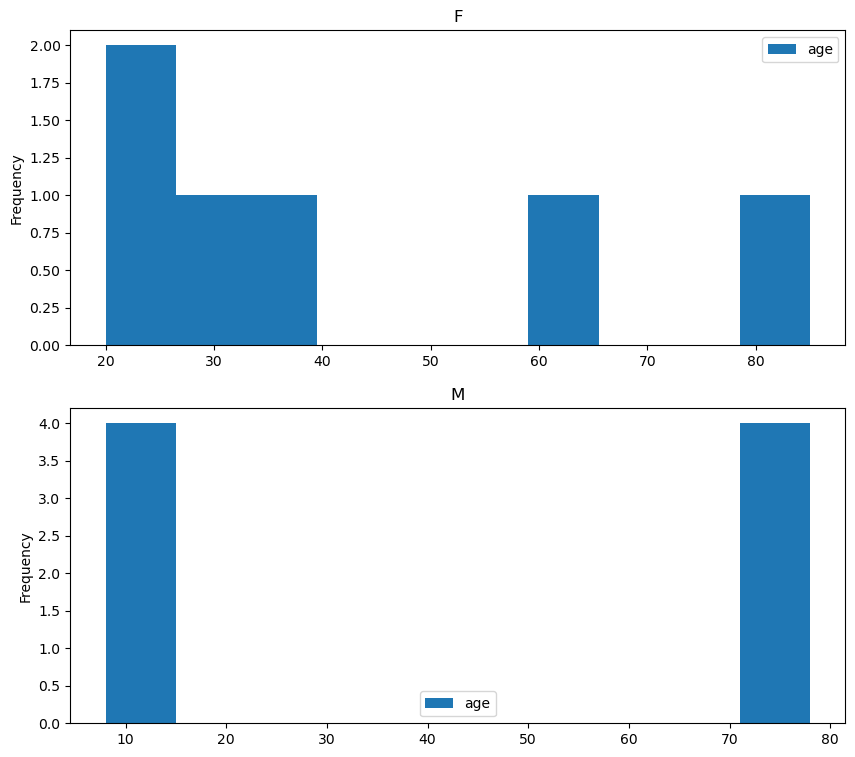

In [9]:
age_list = [8, 10, 12, 14, 72, 74, 76, 78, 20, 25, 30, 35, 60, 85]
df = pd.DataFrame({"gender": list("MMMMMMMMFFFFFF"), "age": age_list})
ax = df.plot.hist(column=["age"], by="gender", figsize=(10, 9))